# Stock price prediction using LSTM neural network and Tensorflow
What do we need here:
1. Load data
2. Scale data for machine learning model
3. Setup neural network
4. Compile model
5. Teach neural netowk and fit this
6. Use the model for prediction
7. Draw the results chart

In [132]:
# Requirements
!pip install yahoo_fin

In [133]:
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf

# Data preparation
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Graphics library
import matplotlib.pyplot as plt

In [134]:
# SETTINGS

DAYS = 5

# Window size or the sequence length, 7 (1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = after tomorrow
LOOKUP_STEPS = range(1, DAYS + 1)

# Stock ticker, APPL
STOCK = 'GOOGL'

# Current date
date_now = tm.strftime('%Y-%m-%d')
date_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

In [135]:
# LOAD DATA
# from yahoo_fin
# for 1104 bars with interval = 1d (one day)
xy12345n_df = yf.get_data(
    STOCK,
    start_date=date_years_back,
    end_date=date_now,
    interval='1d')

In [136]:
xy12345n_df.head()

,open,high,low,close,adjclose,volume,ticker
2021-04-26,115.225998,116.226501,114.865997,115.496498,115.496498,32038000,GOOGL
2021-04-27,115.881500,115.922501,114.307999,114.549004,114.549004,44386000,GOOGL
2021-04-28,119.625000,121.569000,117.661003,117.952003,117.952003,81106000,GOOGL
2021-04-29,119.461502,120.208000,118.692497,119.638000,119.638000,41234000,GOOGL
2021-04-30,118.401001,119.092499,117.328003,117.675003,117.675003,44856000,GOOGL


In [137]:
!date

Sat May  4 09:07:38 PM UTC 2024


In [138]:
%connect_info

{
  "shell_port": 1,
  "iopub_port": 2,
  "stdin_port": 3,
  "control_port": 4,
  "hb_port": 5,
  "ip": "/root/.local/share/jupyter/runtime/kernel-cd1eebf4-3bca-478c-8844-9d8343ecc95a-ipc",
  "key": "",
  "transport": "ipc",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-cd1eebf4-3bca-478c-8844-9d8343ecc95a.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [139]:
# remove columns which our neural network will not use
xy12345n_df = xy12345n_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
# create the column 'date' based on index column
xy12345n_df['date'] = xy12345n_df.index

In [140]:
xy12345n_df

,close,date
2021-04-26,115.496498,2021-04-26
2021-04-27,114.549004,2021-04-27
2021-04-28,117.952003,2021-04-28
2021-04-29,119.638000,2021-04-29
2021-04-30,117.675003,2021-04-30
...,...,...
2024-04-29,166.149994,2024-04-29
2024-04-30,162.779999,2024-04-30
2024-05-01,163.860001,2024-05-01
2024-05-02,166.619995,2024-05-02


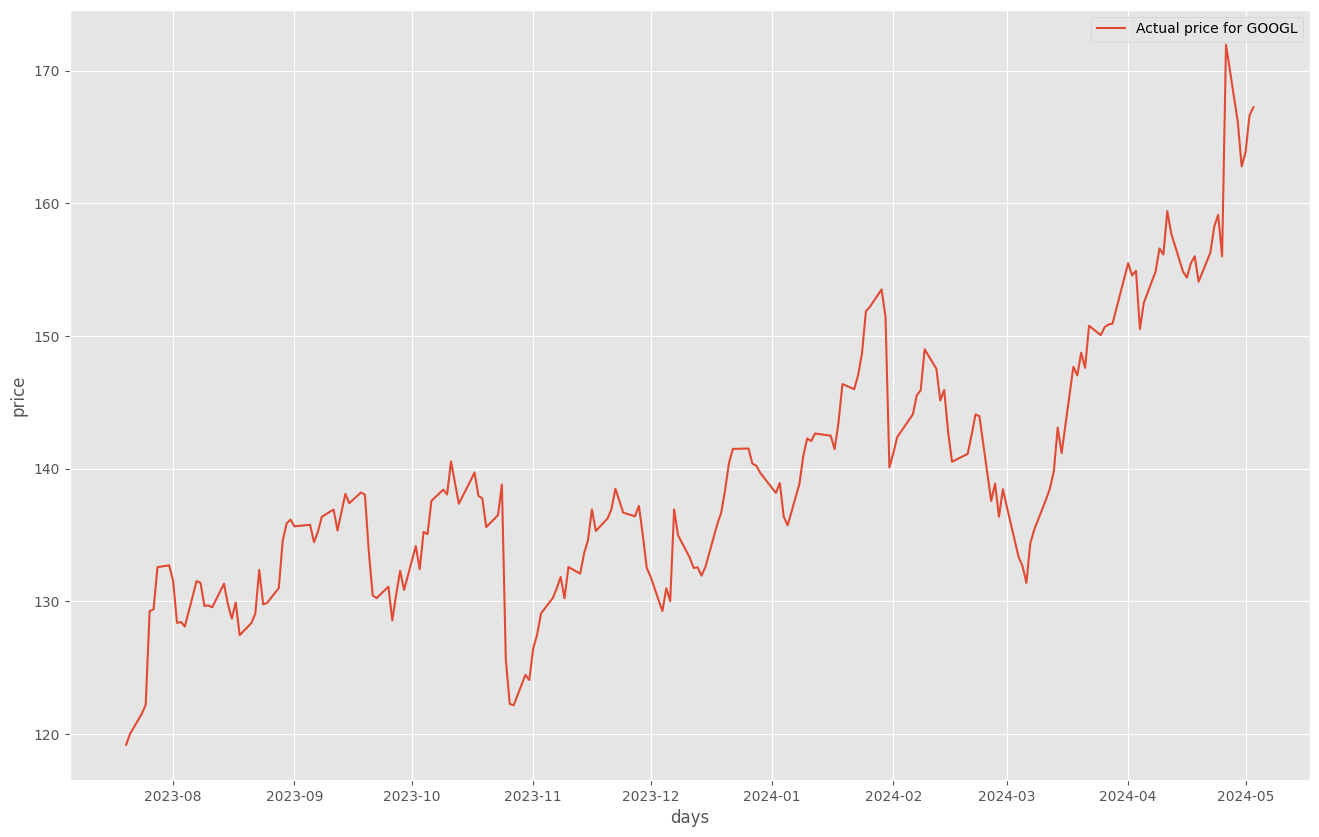

In [141]:
# Let's preliminary see our data on the graphic
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(xy12345n_df['close'][-200:])
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}'])
plt.show()

In [142]:
# Scale data for ML engine
scaler = MinMaxScaler()
xy12345n_df['scaled_close'] = scaler.fit_transform(np.expand_dims(xy12345n_df['close'].values, axis=1))

In [143]:
xy12345n_df

,close,date,scaled_close
2021-04-26,115.496498,2021-04-26,0.362251
2021-04-27,114.549004,2021-04-27,0.351548
2021-04-28,117.952003,2021-04-28,0.389991
2021-04-29,119.638000,2021-04-29,0.409038
2021-04-30,117.675003,2021-04-30,0.386862
...,...,...,...
2024-04-29,166.149994,2024-04-29,0.934478
2024-04-30,162.779999,2024-04-30,0.896408
2024-05-01,163.860001,2024-05-01,0.908608
2024-05-02,166.619995,2024-05-02,0.939788


In [144]:
def PrepareData(days):
  df = xy12345n_df.copy()
  df['future'] = df['scaled_close'].shift(-days)
  last_sequence = np.array(df[['scaled_close']].tail(days))
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['scaled_close'] + ['date']].values, df['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['scaled_close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  # construct the X's and Y's
  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  # convert to numpy arrays
  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

In [145]:
PrepareData(DAYS)

(                 close       date  scaled_close    future
 2021-04-26  115.496498 2021-04-26      0.362251  0.380976
 2021-04-27  114.549004 2021-04-27      0.351548  0.360500
 2021-04-28  117.952003 2021-04-28      0.389991  0.364985
 2021-04-29  119.638000 2021-04-29      0.409038  0.377740
 2021-04-30  117.675003 2021-04-30      0.386862  0.385975
 ...                ...        ...           ...       ...
 2024-04-22  156.279999 2024-04-22      0.822978  0.934478
 2024-04-23  158.259995 2024-04-23      0.845346  0.896408
 2024-04-24  159.130005 2024-04-24      0.855174  0.908608
 2024-04-25  156.000000 2024-04-25      0.819815  0.939788
 2024-04-26  171.949997 2024-04-26      1.000000  0.946792
 
 [757 rows x 4 columns],
 array([[0.8199277 ],
        [0.7982377 ],
        [0.8229779 ],
        [0.8453457 ],
        [0.85517406],
        [0.81981474],
        [1.        ],
        [0.93447804],
        [0.8964076 ],
        [0.90860826],
        [0.93978757],
        [0.94679177]], 

In [146]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['scaled_close']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 8
  EPOCHS = 80

  model.compile(loss='mean_squared_error', optimizer='adam')

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model

In [147]:
# GET PREDICTIONS
predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['scaled_close'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

Epoch 1/80
95/95 [==============================] - 4s 6ms/step - loss: 0.0165
Epoch 2/80
95/95 [==============================] - 1s 8ms/step - loss: 0.0043
Epoch 3/80
95/95 [==============================] - 1s 10ms/step - loss: 0.0041
Epoch 4/80
95/95 [==============================] - 1s 11ms/step - loss: 0.0036
Epoch 5/80
95/95 [==============================] - 1s 11ms/step - loss: 0.0033
Epoch 6/80
95/95 [==============================] - 1s 10ms/step - loss: 0.0035
Epoch 7/80
95/95 [==============================] - 1s 14ms/step - loss: 0.0035
Epoch 8/80
95/95 [==============================] - 2s 16ms/step - loss: 0.0031
Epoch 9/80
95/95 [==============================] - 1s 13ms/step - loss: 0.0028
Epoch 10/80
95/95 [==============================] - 1s 9ms/step - loss: 0.0030
Epoch 11/80
95/95 [==============================] - 1s 10ms/step - loss: 0.0025
Epoch 12/80
95/95 [==============================] - 1s 10ms/step - loss: 0.0024
Epoch 13/80
95/95 [=====================

In [148]:
if bool(predictions) == True and len(predictions) > 0:
  predictions_list = [str(d)+'$' for d in predictions]
  predictions_str = ', '.join(predictions_list)
  message = f'{STOCK} prediction for upcoming 5 days ({predictions_str})'

  print(message)

GOOGL prediction for upcoming 5 days (167.51$, 161.96$, 161.75$, 166.76$, 162.73$)


In [149]:
# Execute model for the whole history range
print(len(PrepareData(DAYS)[0]))
copy_xy12345n_df = xy12345n_df.copy()
print(len(copy_xy12345n_df))
print(len(x_train))
y_predicted = model.predict(x_train)
print(len(y_predicted))
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_xy12345n_df[f'predicted_close'] = y_predicted_transformed

757
762
751
24/24 [==============================] - 0s 3ms/step
751


ValueError: Length of values (760) does not match length of index (762)

In [ ]:
copy_xy12345n_df

In [ ]:
# Add predicted results to the table
date_now = dt.date.today()
date_tomorrow = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)

copy_xy12345n_df.loc[date_now] = [predictions[0], f'{date_now}', 0, 0]
copy_xy12345n_df.loc[date_tomorrow] = [predictions[1], f'{date_tomorrow}', 0, 0]
copy_xy12345n_df.loc[date_after_tomorrow] = [predictions[2], f'{date_after_tomorrow}', 0, 0]

In [ ]:
# Result chart
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_xy12345n_df['close'][-150:].head(147))
plt.plot(copy_xy12345n_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
plt.plot(copy_xy12345n_df['close'][-150:].tail(4))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}',
            f'Predicted price for {STOCK}',
            f'Predicted price for future 3 days'])
plt.show()